In [1]:
%run "PDF text cleaning.ipynb"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2 non-null      int64 
 1   id          2 non-null      object
 2   title       2 non-null      object
 3   abstract    2 non-null      object
 4   published   2 non-null      object
 5   pdf_url     2 non-null      object
 6   full_text   2 non-null      object
 7   summary     2 non-null      object
dtypes: int64(1), object(7)
memory usage: 260.0+ bytes
Paper ID: 2102.07948v4

Abstract: A Kempe swap in a proper coloring interchanges the colors on some maximal
connected 2-colored subgraph. Two $k$-colorings are $k$-equivalent if we can
transform one into the other using Kempe swaps. The triangulated toroidal grid,
$T[m\times n]$, is formed from (a toroidal embedding of) the Cartesian product
of $C_m$ and $C_n$ by adding parallel diagonals inside all 4-faces. Mohar and
Salas showed that not a

In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK data
nltk.download('punkt', quiet=True)

True

In [3]:
def tfidf_summarize(text, top_n = 25):
    
    try:
        # Validate input
        if not isinstance(text, str):
            raise ValueError("Input text must be a string.")
        
        sentences = sent_tokenize(text)
        
        # Handle edge cases
        if not sentences:  # Empty input
            return "Error: No valid sentences found in text."
        if top_n <= 0:
            raise ValueError("Error: top_n must be greater than zero.")
        if len(sentences) <= top_n:
            return text  # If fewer sentences than top_n, return original text
        
        # Apply TF-IDF
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform(sentences)
        # Compute sentence scores
        sentence_scores = np.array(tfidf_matrix.sum(axis = 1)).ravel()
        top_indices = sentence_scores.argsort()[-top_n:][::-1]
        top_sentences = [sentences[i] for i in sorted(top_indices)]
        
        return ' '.join(top_sentences)
    
    except ValueError as ve:
        return f"ValueError: {ve}"
    except Exception as e:
        return f"Unexpected error: {str(e)}"


In [4]:
def led_summarize(text, max_input_length = 4096, max_output_length = 1024):

    try:
        # Load model and tokenizer
        model_name = "allenai/led-base-16384"  
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
        
        # Check for GPU availability
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model = model.to(device)
        
        # Tokenize with attention mask that allows the model to attend to all tokens
        inputs = tokenizer(text, 
                          max_length = max_input_length, 
                          truncation = True, 
                          return_tensors = "pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Generate summary
        global_attention_mask = torch.zeros_like(inputs["input_ids"])
        # Set global attention on the first token
        global_attention_mask[:, 0] = 1
        inputs["global_attention_mask"] = global_attention_mask
        
        summary_ids = model.generate(
            inputs["input_ids"],
            attention_mask = inputs["attention_mask"],
            global_attention_mask = global_attention_mask,
            max_length = max_output_length,
            num_beams = 4,
            length_penalty = 2.0,
            early_stopping = True,
        )
        
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        return summary
    
    except Exception as e:
        return f"LED Summarization Error: {str(e)}"


In [5]:
print("Applying TF-IDF summarization...")
df['tfidf_summary'] = df['clean'].apply(lambda x: tfidf_summarize(preprocess_pdf_text(x), top_n=25))

Applying TF-IDF summarization...


In [6]:
print("Applying LED abstractive summarization...")
df['led_summary'] = df['tfidf_summary'].apply(
    lambda x: led_summarize(x, max_input_length=4096, max_output_length=1024)
)

Applying LED abstractive summarization...


Input ids are automatically padded from 1386 to 2048 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 1704 to 2048 to be a multiple of `config.attention_window`: 1024


In [7]:
print("Final Summaries:")
for idx, row in df.head(3).iterrows():
    print(f"\n\n=== DOCUMENT {idx} ===")
    print(f"\n--- TF-IDF SUMMARY (EXTRACTIVE) ---\n{row['tfidf_summary'][:300]}...")
    print(f"\n--- LED SUMMARY (ABSTRACTIVE) ---\n{row['led_summary']}")
    print("=" * 100)

Final Summaries:


=== DOCUMENT 0 ===

--- TF-IDF SUMMARY (EXTRACTIVE) ---
2.1 An Introduction to Good Templates Given a coloring ϕ of G, our idea is to identify the vertices in one or more independent sets, each of which receives a common color under ϕ. If the resulting graph is 4-degenerate, then all of its 5-colorings are 5equivalent, as shown in Lemma 1; and these 5-co...

--- LED SUMMARY (ABSTRACTIVE) ---
or 30, ensuring that it uses either α or β; this reduces to a case above. 5We must include 12 in the first template; otherwise, adding the bonus vertex w creates a subgraph that is not locally connected, since dG(11, w) = 2, but dH+w(11, w) > 2. Since we have no pair, these repeated colors appear "across" from each other; that is, each color appears on two vertices with 7 as their unique common neighbor. , k} is not used on the closed neighborhood 2For example, begin with the cartesian product of K3 and K2, drawn in the plane, and add a 4-vertex inside each 4-face. To simulate in

In [8]:
def calculate_rouge_scores(reference_text, generated_summary):

    try:
        # Initialize ROUGE scorer with the metrics we want to use
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        
        # Calculate scores
        scores = scorer.score(reference_text, generated_summary)
        
        # Extract F1 scores (balance of precision and recall)
        rouge1_f1 = scores['rouge1'].fmeasure
        rouge2_f1 = scores['rouge2'].fmeasure
        rougeL_f1 = scores['rougeL'].fmeasure
        
        return {
            'rouge1_f1': rouge1_f1,
            'rouge2_f1': rouge2_f1,
            'rougeL_f1': rougeL_f1,
            'average_f1': np.mean([rouge1_f1, rouge2_f1, rougeL_f1])
        }
    except Exception as e:
        print(f"Error calculating ROUGE scores: {str(e)}")
        return {
            'rouge1_f1': 0.0,
            'rouge2_f1': 0.0,
            'rougeL_f1': 0.0,
            'average_f1': 0.0
        }

In [9]:
print("Calculating ROUGE scores for TF-IDF summaries...")
df['tfidf_rouge'] = df.apply(
lambda row: calculate_rouge_scores(row['clean'], row['tfidf_summary']), 
axis=1
    )


print("Calculating ROUGE scores for LED summaries...")
df['led_rouge'] = df.apply(
lambda row: calculate_rouge_scores(row['clean'], row['led_summary']), 
axis=1
    )

Calculating ROUGE scores for TF-IDF summaries...
Calculating ROUGE scores for LED summaries...


In [10]:
print("\n\n=== ROUGE SCORES BY DOCUMENT ===")
for idx, row in df.head(3).iterrows():
    print(f"\n--- DOCUMENT {idx} ROUGE SCORES ---")
    
    print("TF-IDF Summary:")
    print(f"  ROUGE-1: {row['tfidf_rouge']['rouge1_f1']:.4f}")
    print(f"  ROUGE-2: {row['tfidf_rouge']['rouge2_f1']:.4f}")
    print(f"  ROUGE-L: {row['tfidf_rouge']['rougeL_f1']:.4f}")
    print(f"  Average: {row['tfidf_rouge']['average_f1']:.4f}")
    
    print("\nLED Summary:")
    print(f"  ROUGE-1: {row['led_rouge']['rouge1_f1']:.4f}")
    print(f"  ROUGE-2: {row['led_rouge']['rouge2_f1']:.4f}")
    print(f"  ROUGE-L: {row['led_rouge']['rougeL_f1']:.4f}")
    print(f"  Average: {row['led_rouge']['average_f1']:.4f}")
    
    print("-" * 80)



=== ROUGE SCORES BY DOCUMENT ===

--- DOCUMENT 0 ROUGE SCORES ---
TF-IDF Summary:
  ROUGE-1: 0.1537
  ROUGE-2: 0.1507
  ROUGE-L: 0.1537
  Average: 0.1527

LED Summary:
  ROUGE-1: 0.1128
  ROUGE-2: 0.1033
  ROUGE-L: 0.0886
  Average: 0.1016
--------------------------------------------------------------------------------

--- DOCUMENT 1 ROUGE SCORES ---
TF-IDF Summary:
  ROUGE-1: 0.4297
  ROUGE-2: 0.4239
  ROUGE-L: 0.4297
  Average: 0.4278

LED Summary:
  ROUGE-1: 0.2421
  ROUGE-2: 0.2377
  ROUGE-L: 0.1975
  Average: 0.2258
--------------------------------------------------------------------------------


In [11]:
print("\n\n=== AVERAGE ROUGE SCORES ACROSS ALL DOCUMENTS ===")

# For TF-IDF
avg_tfidf_rouge1 = df['tfidf_rouge'].apply(lambda x: x['rouge1_f1']).mean()
avg_tfidf_rouge2 = df['tfidf_rouge'].apply(lambda x: x['rouge2_f1']).mean()
avg_tfidf_rougeL = df['tfidf_rouge'].apply(lambda x: x['rougeL_f1']).mean()
avg_tfidf_avg = df['tfidf_rouge'].apply(lambda x: x['average_f1']).mean()

# For LED
avg_led_rouge1 = df['led_rouge'].apply(lambda x: x['rouge1_f1']).mean()
avg_led_rouge2 = df['led_rouge'].apply(lambda x: x['rouge2_f1']).mean()
avg_led_rougeL = df['led_rouge'].apply(lambda x: x['rougeL_f1']).mean()
avg_led_avg = df['led_rouge'].apply(lambda x: x['average_f1']).mean()

print("TF-IDF Summarization:")
print(f"  Avg ROUGE-1: {avg_tfidf_rouge1:.4f}")
print(f"  Avg ROUGE-2: {avg_tfidf_rouge2:.4f}")
print(f"  Avg ROUGE-L: {avg_tfidf_rougeL:.4f}")
print(f"  Avg Overall: {avg_tfidf_avg:.4f}")

print("\nLED Summarization:")
print(f"  Avg ROUGE-1: {avg_led_rouge1:.4f}")
print(f"  Avg ROUGE-2: {avg_led_rouge2:.4f}")
print(f"  Avg ROUGE-L: {avg_led_rougeL:.4f}")
print(f"  Avg Overall: {avg_led_avg:.4f}")



=== AVERAGE ROUGE SCORES ACROSS ALL DOCUMENTS ===
TF-IDF Summarization:
  Avg ROUGE-1: 0.2917
  Avg ROUGE-2: 0.2873
  Avg ROUGE-L: 0.2917
  Avg Overall: 0.2902

LED Summarization:
  Avg ROUGE-1: 0.1775
  Avg ROUGE-2: 0.1705
  Avg ROUGE-L: 0.1430
  Avg Overall: 0.1637


<Figure size 1200x600 with 0 Axes>

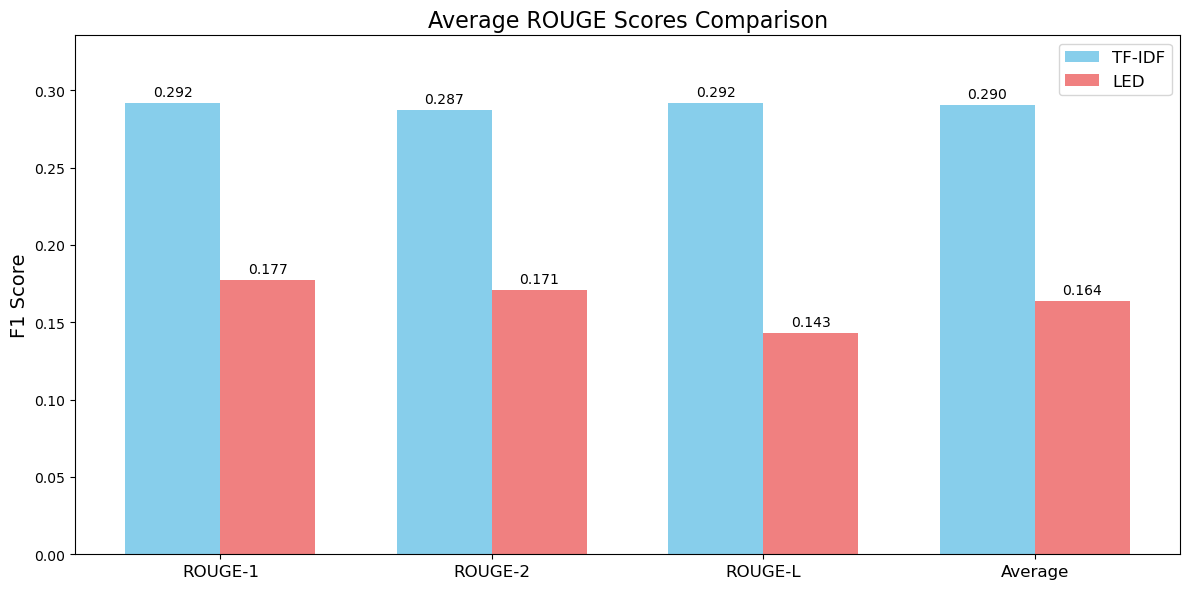

In [12]:
plt.figure(figsize = (12, 6))
metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Average']
tfidf_scores = [avg_tfidf_rouge1, avg_tfidf_rouge2, avg_tfidf_rougeL, avg_tfidf_avg]
led_scores = [avg_led_rouge1, avg_led_rouge2, avg_led_rougeL, avg_led_avg]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize = (12, 6))
tfidf_bars = ax.bar(x - width/2, tfidf_scores, width, label = 'TF-IDF', color = 'skyblue')
led_bars = ax.bar(x + width/2, led_scores, width, label = 'LED', color = 'lightcoral')

ax.set_title('Average ROUGE Scores Comparison', fontsize=16)
ax.set_ylabel('F1 Score', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.legend(fontsize=12)

# Add value labels on top of bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy = (bar.get_x() + bar.get_width() / 2, height),
                    xytext = (0, 3),  # 3 points vertical offset
                    textcoords = "offset points",
                    ha = 'center', va='bottom')

add_value_labels(tfidf_bars)
add_value_labels(led_bars)

plt.ylim(0, max(max(tfidf_scores), max(led_scores)) * 1.15)
plt.tight_layout()
plt.show()

In [13]:

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

smoothie = SmoothingFunction().method4

def calculate_bleu(reference, summary):
    reference_tokens = reference.split()
    summary_tokens = summary.split()
    return sentence_bleu([reference_tokens], summary_tokens, smoothing_function=smoothie)

print("Calculating BLEU scores for TF-IDF summaries...")
df['tfidf_bleu'] = df.apply(lambda row: calculate_bleu(row['clean'], row['tfidf_summary']), axis=1)

print("Calculating BLEU scores for LED summaries...")
df['led_bleu'] = df.apply(lambda row: calculate_bleu(row['clean'], row['led_summary']), axis=1)


Calculating BLEU scores for TF-IDF summaries...
Calculating BLEU scores for LED summaries...


In [14]:
!pip install bert_score
from bert_score import score as bert_score

print("Calculating BERTScores for TF-IDF summaries...")
P, R, F1 = bert_score(df['tfidf_summary'].tolist(), df['clean'].tolist(), lang="en", verbose=True)
df['tfidf_bertscore'] = F1

print("Calculating BERTScores for LED summaries...")
P, R, F1 = bert_score(df['led_summary'].tolist(), df['clean'].tolist(), lang="en", verbose=True)
df['led_bertscore'] = F1


Calculating BERTScores for TF-IDF summaries...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 7.99 seconds, 0.25 sentences/sec
Calculating BERTScores for LED summaries...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 7.84 seconds, 0.26 sentences/sec


In [15]:

print("\n=== AVERAGE BLEU & BERTScores ===")

print("TF-IDF:")
print(f"  Avg BLEU: {df['tfidf_bleu'].mean():.4f}")
print(f"  Avg BERTScore (F1): {df['tfidf_bertscore'].mean():.4f}")

print("\nLED:")
print(f"  Avg BLEU: {df['led_bleu'].mean():.4f}")
print(f"  Avg BERTScore (F1): {df['led_bertscore'].mean():.4f}")



=== AVERAGE BLEU & BERTScores ===
TF-IDF:
  Avg BLEU: 0.0438
  Avg BERTScore (F1): 0.8622

LED:
  Avg BLEU: 0.0009
  Avg BERTScore (F1): 0.8274


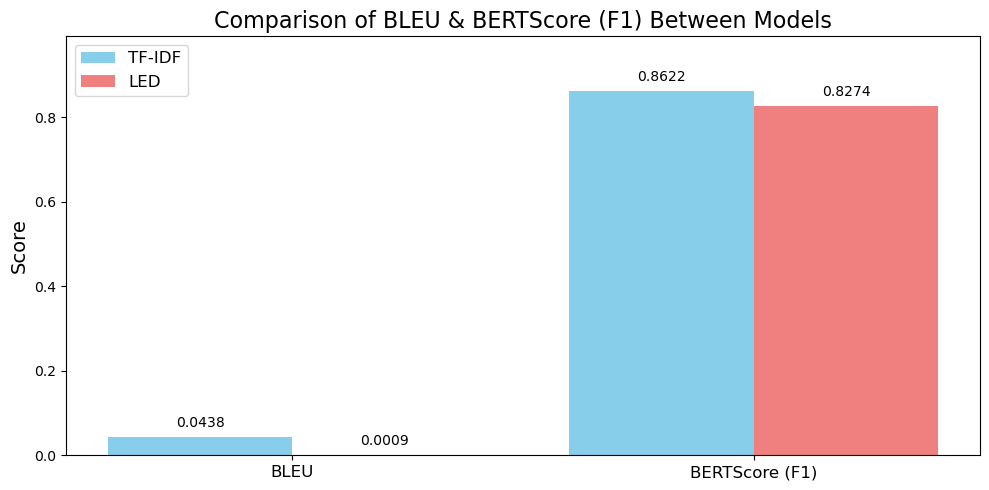

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting BLEU & BERTScore averages dynamically
models = ["TF-IDF", "LED"]
metrics = ["BLEU", "BERTScore (F1)"]

scores = np.array([
    [df['tfidf_bleu'].mean(), df['tfidf_bertscore'].mean()],  # TF-IDF Scores
    [df['led_bleu'].mean(), df['led_bertscore'].mean()]       # LED Scores
])

# Plot settings
x = np.arange(len(metrics))
width = 0.4

fig, ax = plt.subplots(figsize=(10, 5))

# Plot bars
tfidf_bars = ax.bar(x - width/2, scores[0], width, label="TF-IDF", color="skyblue")
led_bars = ax.bar(x + width/2, scores[1], width, label="LED", color="lightcoral")

# Labels and title
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.set_ylabel("Score", fontsize=14)
ax.set_title("Comparison of BLEU & BERTScore (F1) Between Models", fontsize=16)
ax.legend(fontsize=12)

# Add value labels
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha="center", va="bottom")

add_value_labels(tfidf_bars)
add_value_labels(led_bars)

plt.ylim(0, max(scores.flatten()) * 1.15)  # Adjust limit for better visibility
plt.tight_layout()
plt.show()


-Measures n-gram precision, showing how much the generated text matches exact phrases from the reference summary.
-TF-IDF (higher BLEU score) → More exact word match with the reference.
-LED (lower BLEU score) → More abstract paraphrasing, leading to fewer identical word sequences.

-Measures semantic similarity between generated and reference summaries.
-TF-IDF (higher BERTScore) → Preserves more word-level similarity.
-LED (lower BERTScore) → Rewrites sentences more abstractly, leading to slightly lower word alignment.